FIR　EEG-ECoG 共通 EEG 予測 共通

1. FIR 0, IIR 1, LSTM 2
2. EEG-ECoG間でフィルター共通 0, バラバラ 1
3. 予測対象 EEG 0, ECoG 1
4. 予測の仕方 共通 0, NNをわける（フォルター特性が変わる） 1



In [1]:
# -*- coding: utf_8 -*-  
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

import copy
import json
import pandas as pd
import numpy as np
import datetime
import math
import time

import chainer
from chainer import cuda, Function, gradient_check, utils, Variable
from chainer import optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from scipy import signal


import pickle
import sys
import random
import h5py

import nn_class

In [2]:
test=h5py.File('Ma/DeepANES.mat')

ECoG = np.array(test['ECoG'])
EEG = np.array(test['EEG'])
EEG = np.delete(EEG, 14, axis=1)
EEG = EEG.astype('float32')
ECoG = ECoG.astype('float32')

In [3]:
order = 5
batch_size = 1000
time_range = 1000 * 30
start = 0

train_time = [start, time_range+start]
hamming = signal.hamming(train_time[1]-train_time[0])
#training ぶんだけにする
#EEG_t = np.zeros((EEG.shape[0]-order+1, EEG.shape[1], order))
#ECoG_t = np.zeros((ECoG.shape[0]-order+1, ECoG.shape[1], order))
EEG_t = np.zeros((train_time[1]-train_time[0], EEG.shape[1], order))
ECoG_t = np.zeros((train_time[1]-train_time[0], ECoG.shape[1], order))
EEG_tmp = EEG[train_time[0]:train_time[1], :]
ECoG_tmp = ECoG[train_time[0]:train_time[1], :]
for t in range(order):
    for ch in range(EEG.shape[1]):
        #EEG_t[:,ch,t] = EEG[:EEG.shape[0]-order+1, ch] 
        EEG_t[t:,ch,t] = EEG_tmp[:time_range-t, ch] 
    for ch in range(ECoG.shape[1]):
        #ECoG_t[:,ch,t] = ECoG[:ECoG.shape[0]-order+1, ch] 
        ECoG_t[t:,ch,t] = ECoG_tmp[:time_range-t, ch] 
EEG_t = Variable((EEG_t).astype('float32'))
ECoG_t = Variable((ECoG_t).astype('float32'))

In [4]:
def calNN(timeSpacePerceptron, EEG_t, ECoG_t, EEG_filtered_prev, ECoG_filtered_prev, loop):
    loss_history = np.zeros((loop, 1))
    optimizer = optimizers.AdaDelta()
    #optimizer = optimizers.AdaDelta()
    optimizer.setup(timeSpacePerceptron)
    optimizer.add_hook(chainer.optimizer.WeightDecay(0.05))
    #optimizer.add_hook(chainer.optimizer.Lasso(0.5))
    #optimizer.add_hook(chainer.optimizer.GradientClipping(0.5))
    #timeSpacePerceptron.zerograds()
    for i in range(loop):
        timeSpacePerceptron.zerograds()
        x1, x2, EEG_filtered_prev, ECoG_filtered_prev = timeSpacePerceptron(EEG_t, ECoG_t, EEG_filtered_prev, ECoG_filtered_prev, train=True)
        #loss = F.cross_covariance(x1, x2)
        loss = F.mean_squared_error(x1, x2)
        loss.backward()
        optimizer.prepare()
        optimizer.update()
        loss_history[i] = loss.data
    return timeSpacePerceptron, loss_history, EEG_filtered_prev, ECoG_filtered_prev, x1, x2

In [5]:
def loop_calNN(EEG_t, ECoG_t, data_type, loop_num=20):
    EEG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(EEG.shape[1])] #前の出力をいれるところ　(RNN)
    ECoG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(ECoG.shape[1])] #前の出力をいれるところ
    saved_data = dict()
    #outout = []
    out_loss_history = []
    for n in range(loop_num):
        out = []
        loss_history = np.zeros((loop, 1))
        timeSpacePerceptron = nn_class.__dict__["TimeSpacePerceptron{0}".format(data_type)](time_range)
        timeSpacePerceptron, loss_history, EEG_filtered_prev, ECoG_filtered_prev, x1, x2 = calNN(timeSpacePerceptron, EEG_t, ECoG_t, EEG_filtered_prev, ECoG_filtered_prev)
        out_loss_history.append(loss_history)
        #outout.append(timeSpacePerceptron)
    saved_data['loss_history'] = out_loss_history
    saved_data['NN'] = timeSpacePerceptron
    #saved_data['NN'] = outout
    return saved_data, EEG_filtered_prev, ECoG_filtered_prev

def loop_calNN_batch(EEG_t, ECoG_t, data_type, loop_num=20,loop=10, batch_size=1000):
    saved_data = dict()
    #outout = []
    out_loss_history = []
    timeSpacePerceptron = nn_class.__dict__["TimeSpacePerceptron{0}".format(data_type)](batch_size-1)
    for n in range(loop_num):
        for b in range(int(EEG_t.data.shape[0]/batch_size)):
            t1 = b*batch_size
            t2 = (b+1)*batch_size-1
            EEG_filtered_prev = [Variable(np.zeros((batch_size-1, 1)).astype('float32')) for j in range(EEG.shape[1])] #前の出力をいれるところ　(RNN)
            ECoG_filtered_prev = [Variable(np.zeros((batch_size-1, 1)).astype('float32')) for j in range(ECoG.shape[1])] #前の出力をいれるところ
            out = []
            hamming = signal.hamming(batch_size-1)
            eeg = EEG_t[t1:t2,:,:]
            ecog =  ECoG_t[t1:t2,:,:]
            for k in range(eeg.data.shape[2]):
                eeg.data[:,:,k] = eeg.data[:,:,k] * np.array([hamming]*eeg.data.shape[1]).T
                ecog.data[:,:,k] = ecog.data[:,:,k] * np.array([hamming]*ecog.data.shape[1]).T
            timeSpacePerceptron, loss_history, EEG_filtered_prev, ECoG_filtered_prev, x1, x2 = calNN(timeSpacePerceptron, eeg, ecog, EEG_filtered_prev, ECoG_filtered_prev, loop=loop)
            out_loss_history.append(loss_history)
            #outout.append(timeSpacePerceptron)
    saved_data['loss_history'] = out_loss_history
    saved_data['NN'] = timeSpacePerceptron
    #saved_data['NN'] = outout
    return saved_data, EEG_filtered_prev, ECoG_filtered_prev

In [26]:
saved_data = dict()
loop_num = 1 # main
loop = 2000 # local
st = time.time()


# channle をわけない

#data_type ='0000'
#saved_data[data_type],  EEG_filtered_prev, ECoG_filtered_prev =  loop_calNN_batch(EEG_t, ECoG_t, data_type, loop_num=loop_num, loop=loop, batch_size=batch_size)

data_type ='1000'
saved_data[data_type],  EEG_filtered_prev, ECoG_filtered_prev =  loop_calNN_batch(EEG_t, ECoG_t, data_type, loop_num=loop_num, loop=loop, batch_size=batch_size)

#data_type ='2000'
#saved_data[data_type],  EEG_filtered_prev, ECoG_filtered_prev =  loop_calNN_batch(EEG_t, ECoG_t, data_type, loop_num=loop_num, batch_size=batch_size)


print()
print(time.time()-st)


2098.174854040146


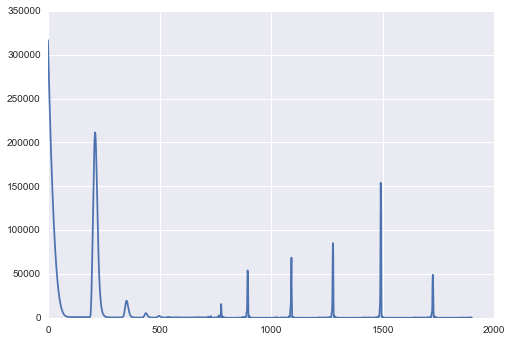

In [27]:
data_type ='1000'
plt.plot(saved_data[data_type]['loss_history'][0][100:])

In [28]:
data_type ='1000'
corr_val = np.zeros((16, int(EEG_t.data.shape[0]/batch_size)))
hamming = signal.hamming(batch_size-1)
for b in range(int(EEG_t.data.shape[0]/batch_size)):
    EEG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(EEG.shape[1])] #前の出力をいれるところ　(RNN)
    ECoG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(ECoG.shape[1])] #前の出力をいれるところ
    t1 = b*batch_size
    t2 = (b+1)*batch_size-1
    x1, x2, EEG_filtered_prev, ECoG_filtered_prev = saved_data[data_type]['NN'](EEG_t[t1:t2,:,:], ECoG_t[t1:t2,:,:], EEG_filtered_prev, ECoG_filtered_prev, train=False)
    for ch in range(16):
        corr_val[ch, b] = np.corrcoef(x1.data[:,ch], x2.data[:,ch])[0, 1]


[[ 0.88431625]
 [ 0.8821595 ]
 [ 0.8174573 ]
 [ 0.87573579]
 [ 0.88953283]
 [ 0.8835931 ]
 [ 0.86495981]
 [ 0.88455616]
 [ 0.89474156]
 [ 0.88662522]
 [ 0.8909688 ]
 [ 0.88872697]
 [ 0.89022761]
 [ 0.88480155]
 [ 0.89048105]
 [ 0.88357931]]


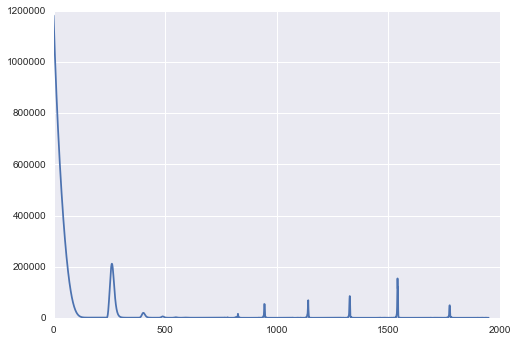

In [29]:
#2000 15/16 2回目
data_type ='1000'
plt.plot(saved_data[data_type]['loss_history'][0][50:])
print(corr_val)

[[ 0.88431625]
 [ 0.8821595 ]
 [ 0.8174573 ]
 [ 0.87573579]
 [ 0.88953283]
 [ 0.8835931 ]
 [ 0.86495981]
 [ 0.88455616]
 [ 0.89474156]
 [ 0.88662522]
 [ 0.8909688 ]
 [ 0.88872697]
 [ 0.89022761]
 [ 0.88480155]
 [ 0.89048105]
 [ 0.88357931]]


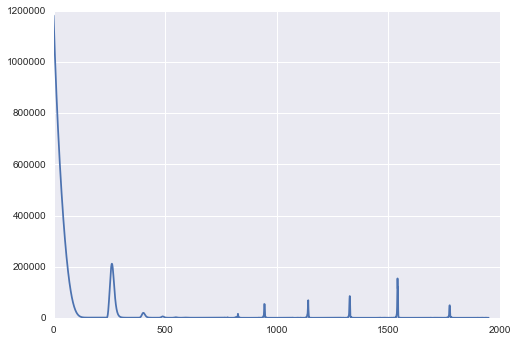

In [30]:
#1500 15/16
data_type ='1000'
plt.plot(saved_data[data_type]['loss_history'][0][50:])
print(corr_val)

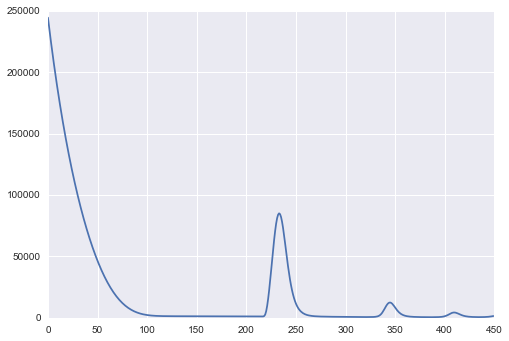

In [18]:
#500 15/16
data_type ='1000'
plt.plot(saved_data[data_type]['loss_history'][0][50:])

In [17]:
#500 15/16
corr_val

array([[ 0.6351987 ],
       [ 0.66279465],
       [ 0.44048552],
       [ 0.74889085],
       [ 0.66208992],
       [ 0.57899623],
       [ 0.75433275],
       [ 0.67818723],
       [ 0.75828296],
       [ 0.63660824],
       [ 0.69275717],
       [ 0.75645993],
       [ 0.75128041],
       [ 0.58148436],
       [ 0.66311939],
       [ 0.56588118]])

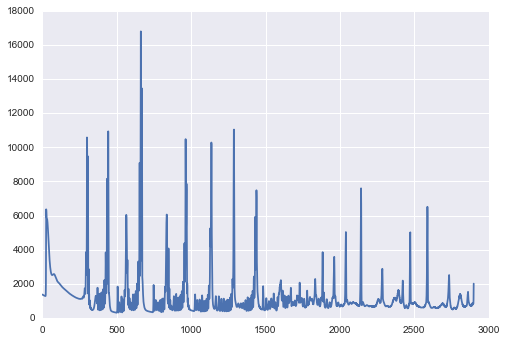

In [12]:
#3000 15/16
data_type ='1000'
plt.plot(saved_data[data_type]['loss_history'][0][100:])

In [9]:
#3000 15/16
corr_val

array([[ 0.7375911 ],
       [ 0.73809407],
       [ 0.64833944],
       [ 0.72829797],
       [ 0.75134167],
       [ 0.72661433],
       [ 0.71424757],
       [ 0.73927231],
       [ 0.74804685],
       [ 0.74159869],
       [ 0.74512812],
       [ 0.74752114],
       [ 0.75687055],
       [ 0.73208339],
       [ 0.74410047],
       [ 0.73081011]])

In [9]:
#2000 0.5
corr_val

array([[ 0.53506963],
       [ 0.53431379],
       [ 0.3454605 ],
       [ 0.47864168],
       [ 0.53358815],
       [ 0.52813748],
       [ 0.47149656],
       [ 0.52928607],
       [ 0.52412083],
       [ 0.53803157],
       [ 0.53131521],
       [ 0.53176392],
       [ 0.5233029 ],
       [ 0.52549998],
       [ 0.54021288],
       [ 0.52964042]])

In [19]:
#2000 15.0/16
corr_val

array([[ 0.88175283],
       [ 0.87947197],
       [ 0.82642778],
       [ 0.89595621],
       [ 0.8877394 ],
       [ 0.88198905],
       [ 0.89097487],
       [ 0.89073267],
       [ 0.90379555],
       [ 0.88268892],
       [ 0.89334878],
       [ 0.90627346],
       [ 0.91272896],
       [ 0.87804896],
       [ 0.8869021 ],
       [ 0.87733368]])

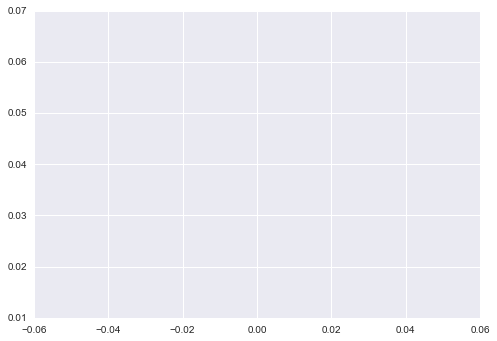

In [10]:
plt.plot(corr_val.T)

In [ ]:
### ここまで

In [60]:
saved_data = dict()
loop = 100
loop_num = 1
st = time.time()

# channle をわけない

data_type ='0000'
saved_data[data_type] =  loop_calNN(EEG_t, ECoG_t, data_type, loop=loop, loop_num=loop_num)

data_type ='1000'
saved_data[data_type],  EEG_filtered_prev, ECoG_filtered_prev =  loop_calNN(EEG_t, ECoG_t, data_type, loop=loop, loop_num=loop_num)

data_type ='2000'
saved_data[data_type],  EEG_filtered_prev, ECoG_filtered_prev =  loop_calNN(EEG_t[:,:,0], ECoG_t[:,:,0], data_type, loop=loop, loop_num=loop_num)

print()
print(time.time()-st)


158.10014009475708


/Users/vv000844/.pyenvi/versions/anaconda3-2.5.0/lib/python3.5/site-packages/chainer/functions/activation/lstm.py:15: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + numpy.exp(-x))


In [82]:
data_type ='1000'

EEG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(EEG.shape[1])] #前の出力をいれるところ　(RNN)
ECoG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(ECoG.shape[1])] #前の出力をいれるところ

x1, x2, EEG_filtered_prev, ECoG_filtered_prev = saved_data[data_type]['NN'](EEG_t, ECoG_t, EEG_filtered_prev, ECoG_filtered_prev, train=False)


for ch in range(16):
    print(np.corrcoef(x1.data[:,ch], x2.data[:,ch])[0, 1])

InvalidType: 
Invalid operation is performed in: Concat (Forward)

Expect: in_types[0].shape[0] == in_types[1].shape[0]
Actual: 10000 != 999

In [63]:
data_type ='2000'

EEG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(EEG.shape[1])] #前の出力をいれるところ　(RNN)
ECoG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(ECoG.shape[1])] #前の出力をいれるところ

x1, x2, EEG_filtered_prev, ECoG_filtered_prev = saved_data[data_type]['NN'](EEG_t[:,:,0], ECoG_t[:,:,0], EEG_filtered_prev, ECoG_filtered_prev, train=False)


for ch in range(16):
    print(np.corrcoef(x1.data[:,ch], x2.data[:,ch])[0, 1])

-0.0416869389259
0.130948456042
0.0700970742688
0.311045227319
0.0378985544823
0.0535104646283
-0.0233822023459
0.0578037100954
-0.0258820790615
nan
0.0715365301592
0.0878812351078
0.41289599889
-0.000382946270612
0.357790984888
0.105311732183


/Users/vv000844/.pyenvi/versions/anaconda3-2.5.0/lib/python3.5/site-packages/chainer/functions/activation/lstm.py:15: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + numpy.exp(-x))
/Users/vv000844/.pyenvi/versions/anaconda3-2.5.0/lib/python3.5/site-packages/numpy/lib/function_base.py:2558: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/vv000844/.pyenvi/versions/anaconda3-2.5.0/lib/python3.5/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


1. 各EEG の相関係数　一番マシなやつはどれか 1 秒ごとの相関係数を計測すべき
あとはデータセットごとの成績（一番マシなモデルで）
一番マシなモデルでのECoG予測
    有意に成績が高いところの空間周波数分布を可視化
2. EEG の方にも空間フィルターをはさみ、CCA っぽくしたやつで EV←いるか？

In [47]:
start = 12000

train_time = [start, time_range+start]
hamming = signal.hamming(train_time[1]-train_time[0])
#training ぶんだけにする
EEG_t = np.zeros((train_time[1]-train_time[0], EEG.shape[1], order))
ECoG_t = np.zeros((train_time[1]-train_time[0], ECoG.shape[1], order))
EEG_tmp = EEG[train_time[0]:train_time[1], :] *np.array([hamming]*EEG.shape[1]).T
ECoG_tmp = ECoG[train_time[0]:train_time[1], :] *np.array([hamming]*ECoG.shape[1]).T
for t in range(order):
    for ch in range(EEG.shape[1]):
        EEG_t[t:,ch,t] = EEG_tmp[:time_range-t, ch] 
    for ch in range(ECoG.shape[1]):
        ECoG_t[t:,ch,t] = ECoG_tmp[:time_range-t, ch] 
EEG_t = Variable((EEG_t).astype('float32'))
ECoG_t = Variable((ECoG_t).astype('float32'))

In [48]:
data_type ='0000'

EEG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(EEG.shape[1])] #前の出力をいれるところ　(RNN)
ECoG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(ECoG.shape[1])] #前の出力をいれるところ

x1, x2, EEG_filtered_prev, ECoG_filtered_prev = saved_data[data_type][0]['NN'](EEG_t, ECoG_t, EEG_filtered_prev, ECoG_filtered_prev, train=False)


for ch in range(16):
    print(np.corrcoef(x1.data[:,ch], x2.data[:,ch])[0, 1])


0.0207187471635
0.0458717261303
-0.0108192695865
0.0661329574022
-0.034606745611
0.0227852900663
-0.0326817656876
0.0546924543054
-0.0116927409141
0.0318454567344
0.0721525861468
0.0412125716064
0.00348209575144
0.0135745480717
0.0102102233428
0.018274019195


In [49]:
data_type ='1000'

EEG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(EEG.shape[1])] #前の出力をいれるところ　(RNN)
ECoG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(ECoG.shape[1])] #前の出力をいれるところ

x1, x2, EEG_filtered_prev, ECoG_filtered_prev = saved_data[data_type]['NN'](EEG_t, ECoG_t, EEG_filtered_prev, ECoG_filtered_prev, train=False)


for ch in range(16):
    print(np.corrcoef(x1.data[:,ch], x2.data[:,ch])[0, 1])

-0.0449766211516
-0.0232906095272
-0.0772777301383
-0.0318539540555
-0.0241463867009
-0.0160971199035
-0.0437096095499
-0.0160508815258
0.0394506079178
-0.0147266687392
-0.121383296745
-0.0159970997966
-0.0150179434717
-0.0382470762072
-0.0824070276322
-0.0562502967309


In [50]:
data_type ='2000'

EEG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(EEG.shape[1])] #前の出力をいれるところ　(RNN)
ECoG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(ECoG.shape[1])] #前の出力をいれるところ

x1, x2, EEG_filtered_prev, ECoG_filtered_prev = saved_data[data_type]['NN'](EEG_t[:,:,0], ECoG_t[:,:,0], EEG_filtered_prev, ECoG_filtered_prev, train=False)


for ch in range(16):
    print(np.corrcoef(x1.data[:,ch], x2.data[:,ch])[0, 1])

-0.119102555124
-0.278238648829
-0.116820860403
-0.080254958995
-0.29244663412
-0.0435385437061
0.047716906933
0.112464034367
-0.106278167708
-0.0720733619743
0.316266828744
-0.0312669475964
0.152641354079
-0.0879843893547
-0.336172864583
-0.0311284166425


/Users/vv000844/.pyenvi/versions/anaconda3-2.5.0/lib/python3.5/site-packages/chainer/functions/activation/lstm.py:15: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + numpy.exp(-x))
